## Importing the necessary modules

In [38]:
import pandas as pd
import numpy as np
import os
import pathlib
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Loading the data

In [21]:
train_dir = pathlib.Path('trainingSet')
test_dir = pathlib.Path('testSet')

In [22]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

42000

In [23]:
zero = list(train_dir.glob('0/*.jpg'))
PIL.Image.open(str(zero[0]))

In [43]:
# Parameters
batch_size = 2100
img_height = 28
img_width = 28

In [44]:
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset='training',
    seed = 123,
    image_size= (img_height, img_width),
    batch_size = batch_size)

Found 42000 files belonging to 10 classes.
Using 33600 files for training.


In [45]:
val_ds = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset='validation',
    seed = 123,
    image_size= (image_height, image_width),
    batch_size = batch_size)

Found 42000 files belonging to 10 classes.
Using 8400 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Visualizing the data

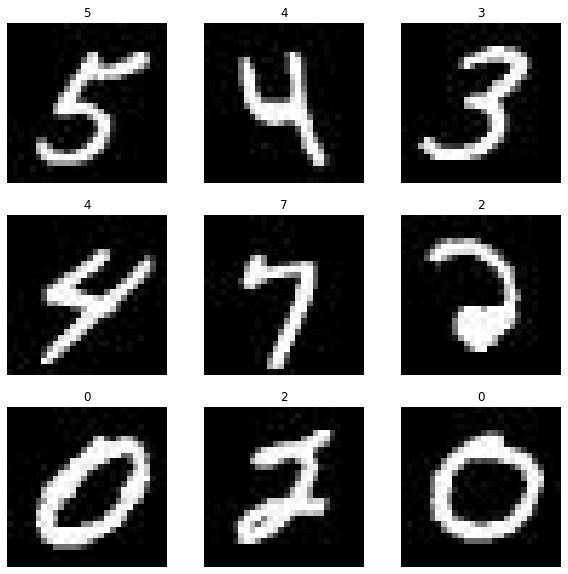

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(2100, 28, 28, 3)
(2100,)


In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Creating the Model

In [51]:
num_classes = 10

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
# Compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

## Training the model

In [54]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 8s 467ms/step - loss: 1.9301 - accuracy: 0.5142 - val_loss: 1.1170 - val_accuracy: 0.7912
Epoch 2/10
16/16 [==============================] - 8s 483ms/step - loss: 0.6416 - accuracy: 0.8270 - val_loss: 0.4077 - val_accuracy: 0.8776
Epoch 3/10
16/16 [==============================] - 7s 444ms/step - loss: 0.3084 - accuracy: 0.9093 - val_loss: 0.2381 - val_accuracy: 0.9268
Epoch 4/10
16/16 [==============================] - 9s 570ms/step - loss: 0.1981 - accuracy: 0.9413 - val_loss: 0.1733 - val_accuracy: 0.9499
Epoch 5/10
16/16 [==============================] - 10s 591ms/step - loss: 0.1447 - accuracy: 0.9566 - val_loss: 0.1330 - val_accuracy: 0.9600
Epoch 6/10
16/16 [==============================] - 10s 583ms/step - loss: 0.1170 - accuracy: 0.9643 - val_loss: 0.1105 - val_accuracy: 0.9674
Epoch 7/10
16/16 [==============================] - 9s 567ms/step - loss: 0.0977 - accuracy: 0.9699 - val_loss: 0.0985 - val_accuracy: 0.9701
Epoc

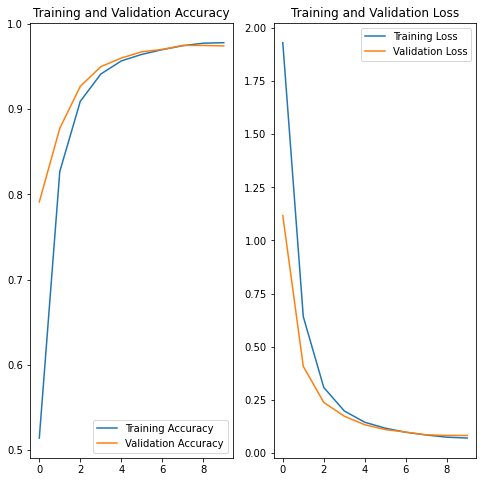

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

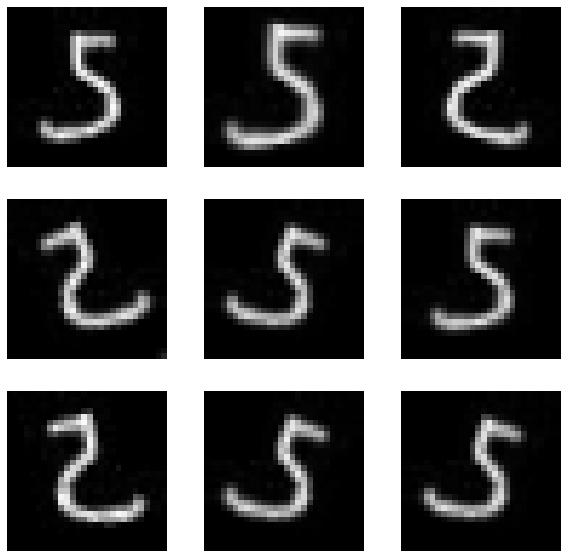

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [58]:
## Dropout

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 3)         0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [61]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 9s 506ms/step - loss: 1.9917 - accuracy: 0.3727 - val_loss: 1.1399 - val_accuracy: 0.6974
Epoch 2/15
16/16 [==============================] - 8s 501ms/step - loss: 1.1501 - accuracy: 0.6179 - val_loss: 0.5917 - val_accuracy: 0.8198
Epoch 3/15
16/16 [==============================] - 9s 533ms/step - loss: 0.7948 - accuracy: 0.7417 - val_loss: 0.4353 - val_accuracy: 0.8645
Epoch 4/15
16/16 [==============================] - 11s 702ms/step - loss: 0.6292 - accuracy: 0.7926 - val_loss: 0.3570 - val_accuracy: 0.8887
Epoch 5/15
16/16 [==============================] - 12s 744ms/step - loss: 0.5337 - accuracy: 0.8248 - val_loss: 0.3120 - val_accuracy: 0.9010
Epoch 6/15
16/16 [==============================] - 11s 669ms/step - loss: 0.4722 - accuracy: 0.8443 - val_loss: 0.2741 - val_accuracy: 0.9156
Epoch 7/15
16/16 [==============================] - 11s 651ms/step - loss: 0.4290 - accuracy: 0.8585 - val_loss: 0.2517 - val_accuracy: 0.9240
Ep

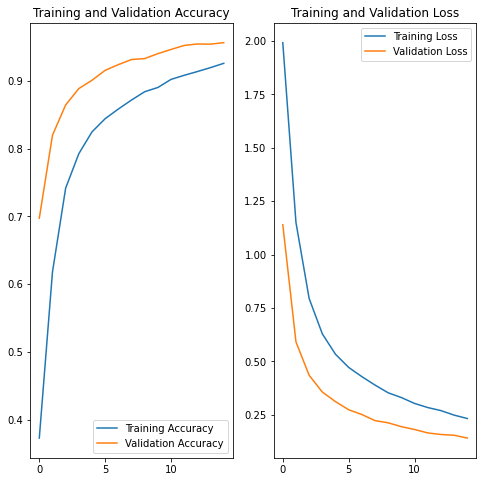

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()